# CHAPTER 14: Subgradient Method

### This code runs simulations for Examples 5 and 9 and generates figures 1, 2, 3 and 4 from Chapter 14:  Subgradient Method (vol I)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Semanur Avşar 

Required Libraries:

1. numpy
2. matplotlib

Required Functions:

1. soft_threshold
2. sign_vector
3. lasso_minimizer
4. generate_logisticd


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from soft_threshold import soft_threshold
from sign_vector import sign_vector
from lasso_minimizer import lasso_minimizer
from generate_logistic import generate_logistic
from tqdm import tqdm

## Example 14.5 (Empirical risks with offset parameters)

We continue with the empirical hinge risk ($14.10$) and include a scalar offset parameter $\theta\in\mathbb{R}$ in the following manner:

$$
P(w,\theta)\;=\;\rho\|w\|^2\;+\;\frac{1}{N}\sum_{m=0}^{N-1}\max\left\{0,\,1-{\gamma}(m)
\left(h_m^{\sf T} w-\theta\right)\right\} \tag{14.19}
$$

This function is now dependent on two parameters, $\{w,\theta\}$; it continues to be strongly  convex relative to these parameters but is  nondifferentiable at all locations $w$ satisfying
$\gamma(m)(h_m^{\sf T} w-\theta)=1$. If we now compute subgradients relative to $\theta$ and $w$ and write down the corresponding subgradient algorithm we get:

$$
\theta(n) = \theta(n-1) - \mu \left(\frac{1}{N}\sum_{m=0}^{N-1}\gamma(m)\,\mathbb{I}\left[\gamma(m) (h_m^{\sf T} w_{n-1}-\theta(n-1)) \leq 1\right]\right) \tag{14.20a}
$$

$$
w_n = \left(1-2\mu\rho\right) w_{n-1} + \mu \left(\frac{1}{N}\sum_{m=0}^{N-1}\gamma(m) h_{m}\,\mathbb{I}\left[\gamma(m) (h_m^{\sf T} w_{n-1}-\theta(n-1)) \leq 1\right]\right) \tag{14.20b}
$$


We can combine these iterations by introducing the augmented $(M+1)-$dimensional quantities:

$$
w' \triangleq \begin{bmatrix} -\theta \\ w \end{bmatrix}, \quad h' \triangleq \begin{bmatrix} 1 \\ h \end{bmatrix} \tag{14.21}
$$


to arrive at the following batch implementation:

$$
w_n' = \begin{bmatrix} 1 & 0 \\ 0 & (1-2\mu\rho)I_M \end{bmatrix} w_{n-1}' + \mu \left(\frac{1}{N}\sum_{m=0}^{N-1}{\gamma}(m) h_{m}' \mathbb{I}\left[ ({\gamma}(m) (h_m')^{\sf T} w_{n-1}' \leq 1 \right] \right) \tag{14.22}
$$


We illustrate the behavior of the algorithm by means of a numerical simulation. The top row of Fig.$~14.1$ plots the learning curve for the subgradient recursion ($14.22$) in linear and normalized logarithmic scales using the parameters:

$$
\mu=0.002,\;\; \rho=1,\;\;M=10,\;\;\;N=200. \tag{14.23}
$$

The logarithmic curve plots

$$
\ln\Bigg(\frac{P(w_n,\theta(n))-P(w^{\star},\theta^{\star})}{\max_{n}\{ P(w_n,\theta(n))-P(w^{\star},\theta^{\star})\}}\Bigg) \tag{14.24}
$$

where $P(w_n,\theta(n))$ denotes the risk values at the successive iterates $(w_n,\theta(n))$ and $P(w^{\star},\theta^{\star})$ is the minimum risk. The subgradient recursion is run for 12,000 iterations at the end of which the limit quantities $(w_n,\theta(n))$ are used as approximations for $(w^{\star},\theta^{\star})$ with the corresponding risk value taken as the approximate minimum risk. In order to simplify the plot of the logarithmic curve, we sample it down by a factor of 100 and place markers every 100 samples.

In [4]:
## l2-regularized SVM
## P(w) = rho \|w\|^2 + (1/N) sum_{n=0}^{N-1} max(0, 1-gamma(m)(h_m'w-theta))

rho = 1 # regularization parameter
mu = 0.002

M = 10
N = 200 # number of data points
L = 5000 # number of iterations

print('wait....generating data')
wo = np.random.randn(M).reshape(-1,1) # parameter model 
thetao = np.random.rand() # the w and theta values are selected randomly, 
                          # which causes the converged values to be different than the book but 
                          # the overall behaviour is the same

p, gamma_vec, H = generate_logistic(N,wo,thetao)

w = np.random.randn(M).reshape(-1,1)  # initial condition
theta = np.random.rand()    # initial condition

P = np.zeros(L).reshape(-1,1)  # risk function
theta_curve = np.zeros(L).reshape(-1,1)

for n in tqdm(range(L)):
    theta_curve[n] = theta
    for m in range(N) :
        h_m = H[:,m].reshape(-1,1) # feature vector
        gamma_m = gamma_vec[m] # label
        a = 1 - gamma_m * ( np.dot(h_m.T, w) - theta )
        P[n] = P[n] + max(0,a)
    P[n] = (1/N)*P[n]
    P[n] = P[n] + rho*(np.linalg.norm(w)**2) #risk value   
    
    
    g=0 #gradient vector for n-th iteration
    gt=0 #gradient for update of theta
    for m in range(N) :
        h_m = H[:,m].reshape(-1,1) # feature vector
        gamma_m = gamma_vec[m]; # label
        a = gamma_m * ( np.dot(h_m.T, w) - theta )
        g = g + np.where(a<=1, gamma_m * h_m, 0)
        gt = gt + np.where(a<=1, gamma_m, 0)

    g = (1/N)*g
    gt = (1/N)*gt
        
    w = (1 - 2 * mu * rho) * w + mu * g; # updated w
    theta = theta - mu * gt; #update theta

ws = w.copy()
thetas = theta[0,0]

Ps = 0

for m in range(N) :
   h_m = H[:,m].reshape(-1-1) # feature vector
   gamma_m = gamma_vec[m] # label
   a = 1 - gamma_m * ( np.dot(h_m.T, w) - thetas )
   Ps = Ps + max(0,a)

Ps = (1/N)*Ps
Ps = Ps + rho * (np.linalg.norm(w)**2) # minimum risk value  
                  
print('limit point w-star')
print(ws)

print('theta-star')
print(thetas)

print('minimum risk value')
print(Ps[0], np.mean(P[L-20:L]))

print('step size')
print(mu)

print('number of points')
print(N)

print('rho')
print(rho)

print('dimension of model')
print(M)

print('number of subgradient iterations')
print(L)

wait....generating data


100%|██████████| 5000/5000 [00:27<00:00, 181.86it/s]

limit point w-star
[[ 0.05732923]
 [-0.09481259]
 [-0.06319972]
 [ 0.02231934]
 [ 0.23700452]
 [ 0.10373995]
 [-0.00565864]
 [ 0.03077597]
 [-0.02710223]
 [-0.02827881]]
theta-star
0.596624632557283
minimum risk value
0.8181852224593325 0.8181872894826301
step size
0.002
number of points
200
rho
1
dimension of model
10
number of subgradient iterations
5000


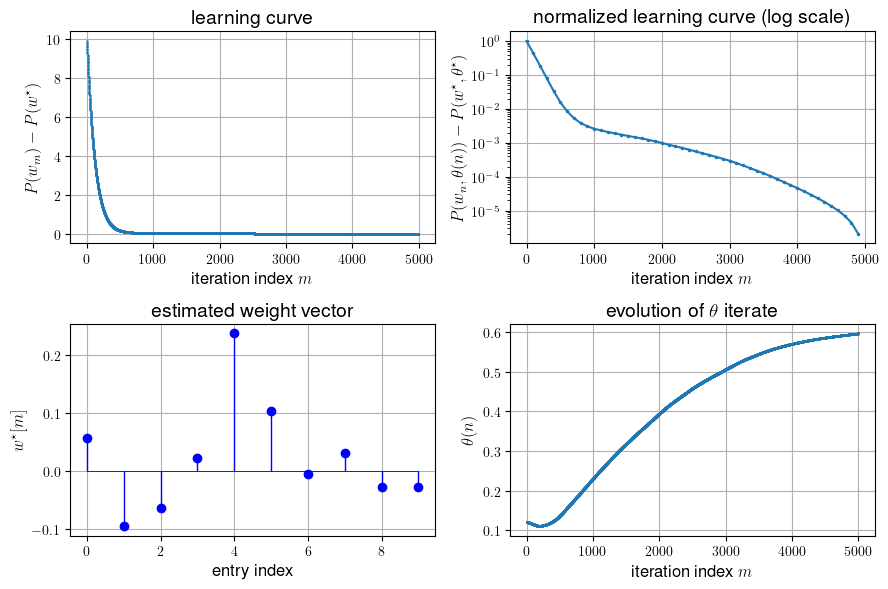

In [5]:
#figure 1 (Learning curves)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.figure(figsize=(9,6))

plt.subplot(221)
plt.plot(range(L), P-Ps, '.', markersize=1.5) # learning curve
plt.xlabel('iteration index $m$', fontsize = 12)
plt.ylabel('$$P(w_m)-P(w^{\star})$$', fontsize = 12)
plt.title('learning curve', fontsize = 14)
plt.grid()

plt.subplot(222)
plt.semilogy(np.arange(0,L,100), (np.abs(P[0:L:100]-Ps))/ max(P-Ps), '-o', markersize=1.5) # abs used to avoid complex log
plt.xlabel('iteration index $m$', fontsize = 12)
plt.ylabel('$$P(w_n,\\theta(n))-P(w^{\star},\\theta^{\star})$$', fontsize = 12)
plt.title('normalized learning curve (log scale)', fontsize = 14)
# plt.ylim([1e-20, 1])
plt.grid()

plt.subplot(223)
markerline, stemlines, baseline = plt.stem(ws, markerfmt='bo', linefmt='b', basefmt='k', label='conjugate gradient')
stemlines.set_linewidth(1)
baseline.set_linewidth(0.5)
plt.xlabel('entry index', fontsize = 12)
plt.ylabel('$$w^{\star}[m]$$', fontsize = 12)
plt.title('estimated weight vector', fontsize = 14)
plt.grid()

plt.subplot(224)
plt.plot(range(L), theta_curve, '.', markersize=1.5) # learning curve
plt.xlabel('iteration index $m$', fontsize = 12)
plt.ylabel('$$\\theta(n)$$', fontsize = 12)
plt.title('evolution of $ \\theta $ iterate', fontsize = 14)
plt.grid()

plt.tight_layout()
plt.savefig('figs/fig1-ch14.pdf', format='pdf')
plt.show()

**Figure 14.1** (*Top*) Learning curves $P(w_n,\theta(n))$ relative to the minimum risk value $P(w^{\star},\theta^{\star})$ over the first 5000 iterations in linear scale (on the left) and in normalized logarithmic scale (on the right) for the $\ell_2-$regularized  hinge risk ($14.19$). The rightmost plot on top illustrates the linear convergence of the risk value toward its limiting behavior. (*Bottom*) The limiting value of the weight iterate $w_n$, is shown on the left and the evolution of the offset iterate $\theta(n)$ is shown on the right.

The $N=200$ data points $\{\gamma(m),h_m\}$ are generated according to a logistic model. Specifically,  a random parameter model $w^a\in\mathbb{R}^{10}$ is selected, and a random collection of feature vectors $\{h_m\}$ are generated with zero-mean and unit-variance Gaussian entries. Then, for each $h_m$, the label $\gamma(m)$ is set to either $+1$ or $-1$ according to the following construction:

$$
\gamma(m) = 
\begin{cases}
+1 & \text{if } \left(\frac{1}{1+e^{-h_m^{\sf T} w^a}}\right) \geq 0.5, \\
-1 & \text{otherwise}
\end{cases} \tag{14.25}
$$


The resulting weight iterate for recursion ($14.22$), denoted by $w^{\star}$, at the end of the 12,000 iterations is shown in the bottom left plot of the figure. The evolution of the $\theta-$iterate is shown in the bottom right plot for the first 5000 iterations; it approaches the value (in the notebook, this value is different than the one in the book since the real theta is generated randomly)

$$
\theta^{\star}\approx 0.8214 \tag{14.26}
$$

The minimum value of the risk function at the limiting points of these iterates is found to be

$$
P(w^{\star},\theta^{\star})\approx 0.6721 \tag{14.27}
$$

The plot in the log scale for the learning curve helps illustrate the linear convergence of $P(w_n,\theta(n)$) toward its state value, as anticipated by result ($14.50$). 

## Example 14.8 (Oscillations can occur)

Assume $w$ is one-dimensional and let us apply the subgradient algorithm ($14.3$) to the minimization of the strongly convex risk function
$P(w)=|w|+{1\over 2}w^2$. This function is not differentiable at $w=0$.  In this case, the subgradient algorithm ($14.3$)  takes the following form with a small step size $\mu>0$:

$$
w_n\;=\;w_{n-1}-\mu\,\textnormal{sign}(w_{n-1})-\mu w_{n-1} \tag{14.45}
$$

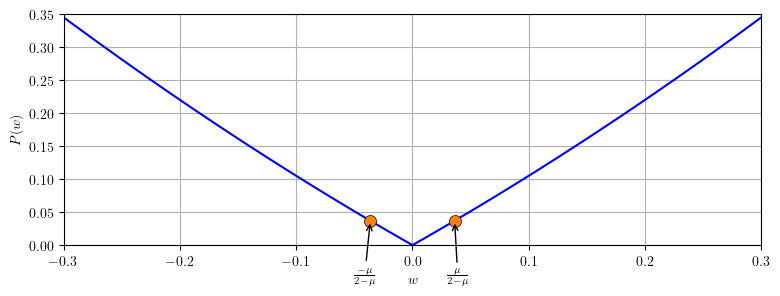

In [33]:
n=0
p = np.zeros( int(0.6/0.01+1) ).reshape(-1,1)
for w in np.arange(-0.3, 0.3 + 0.01 , 0.01) :
    p[n] = np.abs(w) + 0.5 * w**2
    n=n+1

mu = 0.07
x1 = -mu/(2-mu)
x2 = mu/(2-mu)
y1 = np.abs(x1) + 0.5*x1**2
y2 = np.abs(x2) + 0.5*x2**2

x = [x1, x2]
y = [y1, y2]
                                          
plt.figure(figsize=(9,3))
plt.subplot(111)  
plt.plot(np.arange(-0.3, 0.3 + 0.01 , 0.01) ,p, '-b')
plt.scatter(x=x, y=y, zorder=3, c="tab:orange", s=75, edgecolors="black", linewidths=0.5)
plt.annotate('$\\frac{-\mu}{2-\mu}$', xy=(x1, y1), xytext= (-0.05, -0.05), 
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontweight='bold')
plt.annotate('$\\frac{\mu}{2-\mu}$', xy=(x2, y2), xytext= (+0.03, -0.05), 
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontweight='bold')
plt.xlabel('$w$')
plt.ylabel('$P(w)$')
plt.grid()
plt.xlim([-0.3,0.3])
plt.ylim([0,0.35])

plt.savefig("figs/fig2-ch14.pdf")

plt.show()

**Figure 14.2** Starting from $w_{n-1}=-\mu/(2-\mu)$, the subgradient iteration ($14.3$) applied to $P(w)=|w|+{1\over 2}w^2$ oscillates between  $-\mu/(2-\mu)$ and $\mu/(2-\mu)$.

Assume that at some instant in time we arrive at the value $w_{n-1}=-\mu/(2-\mu)$ (or we could consider starting from the initial condition $w_{-1}=-\mu/(2-\mu)$). Then,
iteration ($14.45$) will give $w_n=\mu/(2-\mu)$. At this new location,  iteration ($14.45$) will move  to $w_{n+1}=-\mu/(2-\mu)$ and the process will now repeat. In this way, the iterates will end up oscillating around the optimal solution $ w^{\star}=0$ and the size of the error (distance from the iterate to $ w^{\star}$) remains at $\mu/(2-\mu)=O(\mu)$ for small $\mu$, and it does not get smaller. The situation is illustrated in Fig.$~14.2$


## Example 14.9 (LASSO or $\ell_1$-regularized least-squares)

We revisit the LASSO formulation from Example$~14.1$, where we considered the $\ell_1-$regularized least-squares risk:

$$
P(w) = \alpha \|w\|_{1} + \frac{1}{N}\sum_{m=0}^{N-1} (\gamma(m)-h_m^{\sf T} w)^2 \tag{14.118}
$$


From expression ($14.9$) we know that a subgradient implementation for the LASSO risk is given by

$$
w_{n}=w_{n-1}-\mu\alpha\, \textnormal{sign}(w_{n-1})+\mu\, \left(\frac{2}{N}\sum_{m=0}^{N-1}h_m\left(\gamma(m)-h_m^{\sf T} w_{n-1}\right)\right),\;\;n\geq 0 \tag{14.119}
$$

We illustrate the behavior of the algorithm by means of a numerical simulation. The top row of Fig.$~14.3$ plots the learning curves  with and without exponential  smoothing using the parameters:

$$
\mu=0.002,\;\; \alpha=0.7,\;\;\kappa=0.95,\;\;M=10,\;\;\;N=200. \tag{14.120}
$$

In [29]:
# l1-regularied LASSO
# P(w) = alpha\|w\|_1 + (1/N)\sum_{n=0}^{N-1} (gamma(m)-h_m' w)^2

alpha = 0.7 # regularization parameter
mu = 0.002  # step-size
kappa = 0.95 # used for smoothing
S = 0        # used for smoothing

M = 10
N = 200  # number of data points
L = 5000 # number of subgradient iterations

# generating data
print('wait...generating data')
stdv = 0.01 # standard deviation of measurement noise
zo = np.random.randn(M).reshape(-1,1) # randomly chosen parameter for logistic model
H = np.random.randn(M,N) # feature vectors; one per column
gamma_vec = np.dot(H.T, zo) + stdv*np.random.randn(N).reshape(-1,1)
ws, Ps = lasso_minimizer(alpha, gamma_vec, H) # approximate estimate for ws and minimum risk value

w = np.random.randn(M).reshape(-1,1) # initial condition
winit = w.copy()      # save initial condition
wbar=w.copy()
P = np.zeros(L).reshape(-1,1)    # risk function
Pbar = np.zeros(L).reshape(-1,1) # risk function evaluated at smoothed iterates.

Pbest = np.zeros(L).reshape(-1,1) # risk values at the successive pocket variables
wp = winit[M-1,0]    # initial condition for pocket variable
Pp = alpha*np.linalg.norm(winit,1)+(1/N)*( np.linalg.norm(gamma_vec-np.dot(H.T, winit)**2) ) # initial pocket risk value

for n in tqdm(range(L)) :    
    for m in range(N) :
        h_m = H[:,m].reshape(-1,1) # feature vector
        gamma_m = gamma_vec[m] # label
        a = gamma_m - np.dot(h_m.T, w)
        abar = gamma_m - np.dot(h_m.T, wbar)
        P[n] = P[n] + a**2
        Pbar[n]= Pbar[n] + abar**2

    P[n] = (1/N)*P[n]
    P[n] = P[n] + alpha * np.linalg.norm(w,1) # risk value   
    
    if P[n] <= Pp :
        wp = w.copy()
        Pp = P[n]
                                          
    Pbest[n] = Pp
    
    Pbar[n] = (1/N)*Pbar[n]
    Pbar[n] = Pbar[n] + alpha*np.linalg.norm(wbar,1) # risk value   

    g=0 # gradient vector for n-th iteration
    for m in range(N) :
        h_m = H[:,m].reshape(-1,1) # feature vector
        gamma_m = gamma_vec[m] # label
        a = gamma_m - np.dot(h_m.T, w)
        g = g + 2 * h_m * a

    g = -(1/N) * g
    g = g + alpha*sign_vector(w)
    
    w = w - mu*g  # updated w
    
    S = kappa*S+1
    wbar = (1-(1/S)) * wbar + (1/S) * w #smoothed estimate  

print('limit points w, wbar and minimizer w-star')
print(w, ',')
print(wbar, ',')
print(ws)

Ps1   = alpha * np.linalg.norm(w,1) + ( np.linalg.norm( gamma_vec - np.dot(H.T, w) ) ** 2) / N
Psbar = alpha*np.linalg.norm(wbar,1) + ( np.linalg.norm(gamma_vec - np.dot(H.T, wbar) ) **2) / N

print('miFnimum risk value and estimated limit risk value and norms (w-ws)^2 and (wbar-ws)^2')
print(Ps[0],',', Ps1,',', Psbar, ',', np.mean(P[L-6:L]),',', np.linalg.norm(w-ws)**2,',', np.linalg.norm(wbar-ws)**2)

print('step size')
print(mu)

print('kappa for smoothing')
print(kappa)

print('number of points')
print(N)

print('alpha')
print(alpha)

print('dimension of model')
print(M)

print('number of subgradient iterations')
print(L)

wait...generating data


100%|██████████| 5000/5000 [00:21<00:00, 232.07it/s]

limit points w, wbar and minimizer w-star
[[ 3.37057321e-01]
 [-1.56101325e-03]
 [ 7.12944899e-04]
 [-9.84271294e-01]
 [ 6.75077627e-01]
 [-1.30322061e-03]
 [-1.07563722e+00]
 [-1.76083733e-01]
 [-3.08073104e-01]
 [-1.04453006e-03]] ,
[[ 3.37056220e-01]
 [-5.09969645e-04]
 [ 8.35035480e-04]
 [-9.84270045e-01]
 [ 6.75078013e-01]
 [-4.10082315e-04]
 [-1.07563680e+00]
 [-1.76083562e-01]
 [-3.08072920e-01]
 [-1.04726151e-03]] ,
[[ 0.33685339]
 [ 0.        ]
 [ 0.        ]
 [-0.98429927]
 [ 0.67493328]
 [ 0.        ]
 [-1.07567508]
 [-0.17611622]
 [-0.30811746]
 [ 0.        ]]
miFnimum risk value and estimated limit risk value and norms (w-ws)^2 and (wbar-ws)^2
3.326949744379823 , 3.328758786704015 , 3.327856138065726 , 3.328455659374105 , 5.802142238477663e-06 , 2.289733936907695e-06
step size
0.002
kappa for smoothing
0.95
number of points
200
alpha
0.7
dimension of model
10
number of subgradient iterations
5000


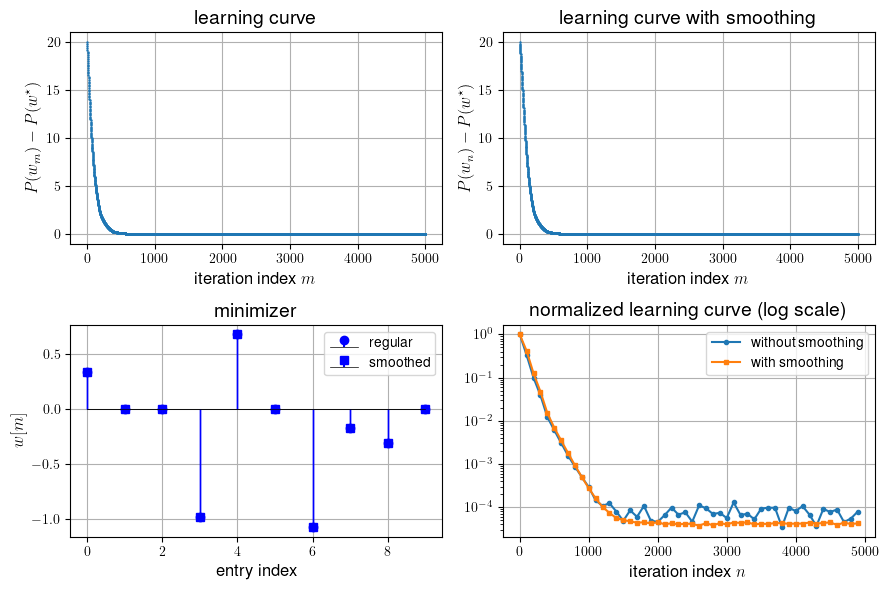

In [30]:
#figure 3 (Learning curves)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.figure(figsize=(9,6))

plt.subplot(221)
plt.plot(range(L), P-Ps, '.', markersize=1.5) # learning curve
plt.xlabel('iteration index $m$', fontsize = 12)
plt.ylabel('$$P(w_m)-P(w^{\star})$$', fontsize = 12)
plt.title('learning curve', fontsize = 14)
plt.grid()
                                          
plt.subplot(222)
plt.plot(range(L), Pbar-Ps, '.', markersize=1.5) # learning curve
plt.xlabel('iteration index $m$', fontsize = 12)
plt.ylabel('$$P(w_n)-P(w^{\star})$$', fontsize = 12) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
plt.title('learning curve with smoothing', fontsize = 14)
plt.grid()

plt.subplot(223)
                                          
markerline, stemlines, baseline = plt.stem(w, markerfmt='bo', linefmt='b', basefmt='k', label='regular')
stemlines.set_linewidth(1)
baseline.set_linewidth(0.5) 
                                          
markerline, stemlines, baseline = plt.stem(w, markerfmt='bs', linefmt='b', basefmt='k', label='smoothed')
stemlines.set_linewidth(1)
baseline.set_linewidth(0.5) 
                                        
plt.xlabel('entry index', fontsize = 12)
plt.ylabel('$$w[m]$$', fontsize = 12)
plt.title('minimizer', fontsize = 14)
plt.legend()
plt.grid()

plt.subplot(224)
plt.semilogy(np.arange(0,L,100), (P[0:L:100]-Ps)/max(P-Ps), '-o', markersize=3, label="without smoothing") 
plt.semilogy(np.arange(0,L,100), (Pbar[0:L:100]-Ps)/max(P-Ps), '-s', markersize=3, label="with smoothing") # learning curve
plt.xlabel('iteration index $n$', fontsize = 12)
#plt.ylabel('$$P(w_n)-P(w^{\star})$$', fontsize = 12)
plt.title('normalized learning curve (log scale)', fontsize = 14)
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('figs/fig3-ch14.pdf', format='pdf')
plt.show()                                        

**Figure 14.3** (*Top*) Learning curves $P(w_n)$ relative to the minimum risk value $P(w^{\star})$ for the regular LASSO subgradient recursion ($14.119$) ({\em left}) and for the smoothed version (*right*) over the first 5000 iterations. The lower plot on the right compares these curves in logarithmic scale and illustrates how the smoothed version has superior "steady-state" behavior. The lower plot on the left shows the limiting minimizers obtained by applying the regular subgradient recursion ($14.119$) or its smoothed version according to construction ($14.99$). The limit values of these minimizers approach each other.

The smoothed implementation follows construction ($14.99$) where the weight iterates are smoothed to $\bar{w}_n$.  The regular subgradient recursion ($14.119$) is run for 5000 iterations at the end of which the limit quantity $w_n$ is used as an approximation for $w^{\star}$ with the corresponding risk value taken as  $P(w^{\star})$. The smoothed version of the recursion is also run for the same number of iterations, and we know from the convergence analysis that $\bar{w}_n$  will approach $w^{\star}$, albeit with a smaller risk value.
 
The $N=200$ data points $\{\gamma(m),h_m\}$ are generated according to a linear model of the form 

$$
\gamma(m) = h_m^{\sf T} w^a + v(m) \tag{14.121}
$$

where the $\{v(m)\}$ are realizations of a zero-mean Gaussian noise with variance $10^{-4}$, while the entries of each $h_m$ are generated from a Gaussian distribution with zero mean and unit variance. The entries of the model $w^{a}\in\mathbb{R}^{10}$ are also generated from a Gaussian distribution with zero mean and unit variance. 
 
The resulting weight iterates, obtained under the regular subgradient algorithm (without smoothing) and under the smoothed version, are shown on the left in the bottom plot of the figure. It is seen that they approach the same value. The bottom-right plot compares the learning curves in normalized logarithmic scale. In order to simplify the plot, the learning curves are downsampled by a factor of 100, meaning that one marker is shown for every 100 values over a run of $5,000$ iterations. It is seen that the smoothed version of the algorithm tends to a lower "steady-state" level, as anticipated by  result ($14.93$). 
 
Recall that result ($14.93$) ensures that the smoothed iterates $\bar{w}_n$ of the subgradient recursion generate risk values $P(\bar{w}_n)$ that converge toward an $O(\mu)-$neighborhood of $P(w^{\star})$, while the regular subgradient recursion ($14.119$) generates risk values $P(w_n)$  that approach a larger $O(\sqrt{\mu})-$neighborhood of $w^{\star}$. This latter effect is illustrated in Fig.$~14.4$, where we repeat the simulation for different values of the step-size parameter, namely, 

$$
\mu\in\{0.0001,\, 0.0002,\, 0.0005,\, 0.001,\, 0.002,\, 0.005,\, 0.007\} \tag{14.122}
$$

For each step size, the regular and smoothed recursions are run for 50,000 iterations. The average of the last 50 risk values, $P(w_n)$ or $P(\bar{w}_n)$, are used as approximations for the limiting risk values, namely, $P(w_n)$ and $P(\bar{w}_n)$ as $n\rightarrow\infty$. The figure plots the values of $P(w_{\infty})-P(w^{\star})$ and 
$P(\bar{w}_{\infty})-P(w^{\star})$ as functions of the step size parameter. The plot on the left uses a linear scale while the plot on the right uses a normalized logarithmic scale for both axes. It is  evident that smoothing improves the steady-state performance level.  

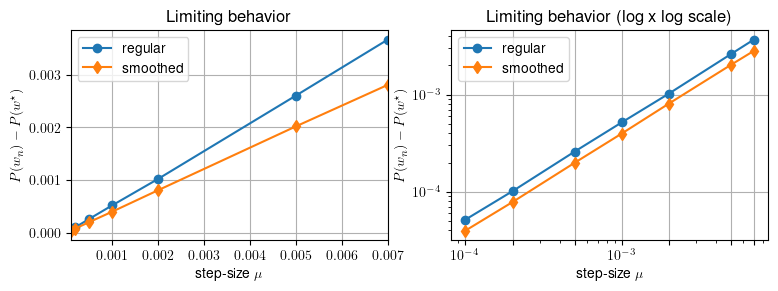

In [12]:
## assessing how P(w_n)-P(ws) behaves in comparison to sqrt(mu)                                          
mu_vec =np.array([0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.007])                                                                                 

M = 10
N = 200   # number of data points
L = 50000 # number of iterations

w = np.random.randn(M).reshape(-1,1)
winit = w.copy()
wbar = w.copy()
                                          
K = max(mu_vec.shape)
Plimit = np.zeros(K).reshape(-1,1)
Plimitbar = np.zeros(K).reshape(-1,1)
Pmin = np.zeros(K).reshape(-1,1)                                            
                                                                                                                   
for k in range(K) : # iterate over step-sizes
    mu = mu_vec[k]
    w = winit.copy() # initial condition
    wbar = w.copy()
    P = np.zeros(L).reshape(-1,1) # risk function
    Pbar = np.zeros(L).reshape(-1,1)
    S = 0
    
    for n in range(L) :
        for m in range(N) :
            h_m = H[:,m].reshape(-1,1) # feature vector
            gamma_m = gamma_vec[m] # label
            a = gamma_m - np.dot(h_m.T, w)
            abar = gamma_m - np.dot(h_m.T, wbar)
            P[n] = P[n] + a**2;
            Pbar[n] = Pbar[n] + abar**2
       
        P[n] = (1/N)*P[n]
        P[n] = P[n] + alpha*np.linalg.norm(w,1) #risk value   

        Pbar[n] = (1/N)*Pbar[n]
        Pbar[n] = Pbar[n] + alpha*np.linalg.norm(wbar,1) #risk value   

        g=0 #gradient vector for n-th iteration
        for m in range(N) : 
            h_m = H[:,m].reshape(-1,1) # feature vector
            gamma_m = gamma_vec[m] # label
            a = gamma_m- np.dot(h_m.T, w)
            g = g + 2*h_m*a

        g = -(1/N)*g
        g = g + alpha*sign_vector(w)

        w = w - mu*g # updated w

        S = kappa*S+1
        wbar = (1-(1/S))*wbar + (1/S)*w #smoothed estimate

    Plimit[k] = np.mean(P[L-50:L]) # estimating the limit risk value
    Plimitbar[k] = np.mean(Pbar[L-50:L]) # estimating the limit risk value
    Pmin[k] = Ps # minimum risk value
                                          
DeltaP = Plimit - Pmin
DeltaPbar = Plimitbar - Pmin

# figure 4 (excess risk vs step-size)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.figure(figsize=(9,6))                                          

plt.subplot(221)
plt.plot(mu_vec,DeltaP,'-o', label = 'regular') # learning curve
plt.plot(mu_vec,DeltaPbar,'-d', label = 'smoothed') # learning curve
plt.xlabel('step-size $\mu$')
plt.ylabel('$$P(w_n)-P(w^{\star})$$')
plt.title('Limiting behavior')
plt.xlim([min(mu_vec) ,max(mu_vec)])
plt.legend()
plt.grid()

plt.subplot(222)
plt.loglog(mu_vec,DeltaP,'-o', label = 'regular') # learning curve
plt.loglog(mu_vec,DeltaPbar,'-d', label = 'smoothed') # learning curve
plt.xlabel('step-size $\mu$')
plt.ylabel('$$P(w_n)-P(w^{\star})$$')
plt.title('Limiting behavior (log x log scale)')
plt.xticks(mu_vec)
plt.legend()
plt.grid()
plt.savefig('figs/fig4-ch14.pdf', format='pdf')
plt.show()

**Figure 14.4** (*Left*) Values of $P(w_{\infty})-P(w^{\star})$ and $P(\bar{w}_{\infty})-P(w^{\star})$ as functions of the step size parameter using a linear scale. (*Right*) Values of $P(w_{\infty})-P(w^{\star})$ and $P(\bar{w}_{\infty})-P(w^{\star})$ as functions of the step-size parameter using a normalized logarithmic scale for both axes. The plots illustrate the expected  $O(\mu)$ versus $O(\sqrt{\mu})$ behavior for the smoothed and nonsmoothed subgradient LASSO recursion. 